# Time Series with Python

Comprehensive Guide to Time Series Analysis in Python

Notebooks based on:
- Libro: Hands-on Machine Learning with Scikit Learn, Keras & Tensorflow
- Libro: Deep Learning for Time Series Forecasting
- https://www.machinelearningplus.com/time-series/time-series-analysis-python/
- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/?#
- https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a

Thanks to @AndreaVidali: https://github.com/AndreaVidali for the support and useful material on the Time Series

## What is a Time Serie?

Time series is a sequence of observations recorded at regular or irregular time intervals.

Depending on the frequency of observations, a time series may typically be hourly, daily, weekly, monthly, quarterly and annual. Sometimes, you might have seconds and minute-wise time series as well, like, number of clicks and user visits every minute etc.

An example of a time series are financial securities or sensor data

**Why even analyze a time series?**

Because it is the foundamental preparatory step before you develop a forecast of the series to better understand how the data are and evolve during time.

Besides, time series forecasting has enormous commercial significance because stuff that is important to a business like demand and sales, number of visitors to a website, stock price etc are essentially time series data.

It is important to remember that time series are one of the most frequent types of data you have to deal with in the world of work.

So what does analyzing a time series involve?

Time series analysis involves understanding various aspects about the inherent nature of the series so that you are better informed to create meaningful and accurate forecasts.

## Why So Special? 

As the name suggests, TS is a collection of data points collected at constant time intervals. These are analyzed to determine the long term trend so as to forecast the future or perform some other form of analysis. But what makes a TS different from say a regular regression problem? There are 2 things:

- **It is time dependent**. So the basic assumption of a linear regression model that the observations are independent doesn’t hold in this case.
- Along with an increasing or decreasing trend, most TS have some form of **seasonality trends**, i.e. variations specific to a particular time frame. For example, if you see the sales of a woolen jacket over time, you will invariably find higher sales in winter seasons.

#### Pannel Data
A very important concept is that of the **pannel data**

Panel data is also a time based dataset.

The difference is that, in addition to time series, it also contains **one or more related variables that are measured for the same time periods**

Typically, the columns present in panel data contain **explanatory variables** that can be helpful in predicting the Y, provided those columns will be available at the future forecasting period.

An example of panel data is shown below.

In [1]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics
from scipy import interpolate

Run Library of usefull function for TS

In [2]:
%run -i 'ts.py'

In [3]:
# EXAMPLE OF TIME SERIE (DRUG DATASET)

# Import as Dataframe
df_drugs = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
print(f'Shape: {df_drugs.shape}')
df_drugs.head()

Shape: (204, 2)


,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [4]:
# EXAMPLE OF PANNEL DATA
# dataset source: https://github.com/rouseguy

df_pannel = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/MarketArrivals.csv')
df_pannel = df_pannel.loc[df_pannel.market=='MUMBAI', :]
df_pannel.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
6654,MUMBAI,January,2004,267100,719,971,849,MS,MUMBAI,January-2004
6655,MUMBAI,January,2005,275845,261,513,387,MS,MUMBAI,January-2005
6656,MUMBAI,January,2006,228000,315,488,402,MS,MUMBAI,January-2006
6657,MUMBAI,January,2007,205200,866,1136,997,MS,MUMBAI,January-2007
6658,MUMBAI,January,2008,267550,348,550,448,MS,MUMBAI,January-2008


In [5]:
# MANUALLY GENERATION OF TIME SERIE

def generate_time_series(batch_size, n_steps):
    """
    Generate a new time serie based on Batch_size and n_steps.
    Return a Numpy array and Pandas Dataframe
    """
    
    freq1, freq2, offset1, offset2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0,1,n_steps)
    series = 0.5 * np.sin((time-offset1) * (freq1*10+10)) #wave1
    series += 0.2 * np.sin((time-offset2) * (freq2 *20+20)) #wave2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) #noise
    
    serie_generated = series[...,np.newaxis].astype(np.float32)
    print(f"Serie Generated: {serie_generated.shape}")
    
    #Transform numpy array generated to dataframe
    df_gen = pd.DataFrame(data=serie_generated[0:1000,0:,0])    # values
    print(f'Shape: {df_gen.shape}')
    
    print("Generation Completed")
    
    return serie_generated, df_gen


#Generate an example time series (using function)
n_steps = 50
series, df_gen = generate_time_series(10000, n_steps + 1)


Serie Generated: (10000, 51, 1)
Shape: (1000, 51)
Generation Completed


In [6]:
# AIR PASSENGERS DATA

# The data contains a particular month and number of passengers travelling in that month. 
#In order to read the data as a time series, we have to pass special arguments to the read_csv command:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
air_pass = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)

air_pass.columns = ['value']
date = air_pass.index
air_pass['date'] = date
air_pass.reset_index(drop=True, inplace=True)

print('\n Parsed Data:')
print(air_pass.head())
print(f'Data Shape: {air_pass.shape}') 


 Parsed Data:
   value       date
0    112 1949-01-01
1    118 1949-02-01
2    132 1949-03-01
3    129 1949-04-01
4    121 1949-05-01
Data Shape: (144, 2)


In [7]:
# FPP R PACKAGE EXAMPLE DATA

# Time series data source: fpp pacakge in R.
df = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')
df_missing = pd.read_csv('a10-missing.csv', parse_dates=['date'], index_col='date')

print(f'Full data: {df.shape}')
print(f'Manual Missing data: {df_missing.shape}')

Full data: (204, 1)
Manual Missing data: (204, 1)


## Visualize a Time Serie

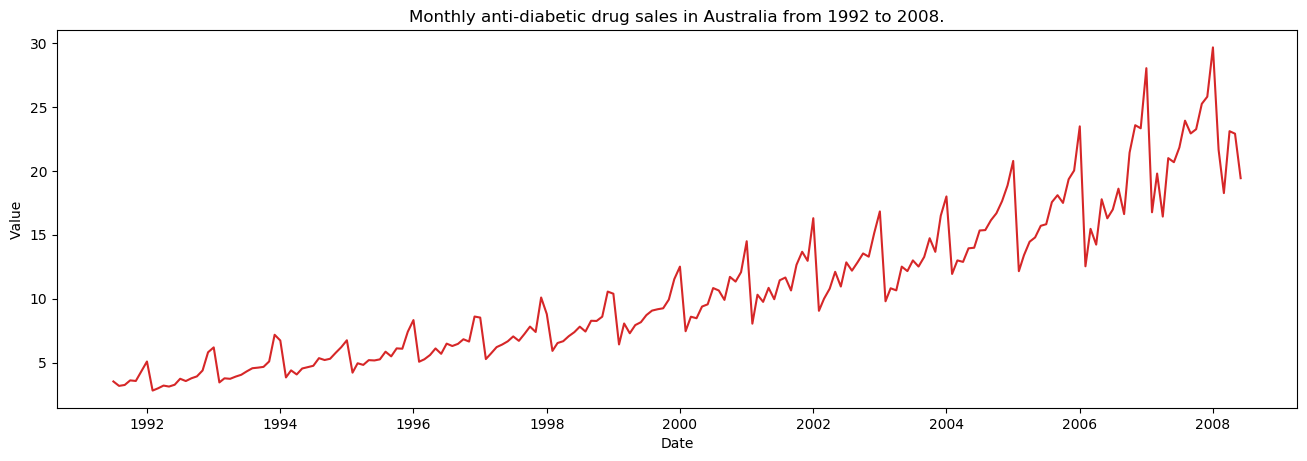

In [8]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')

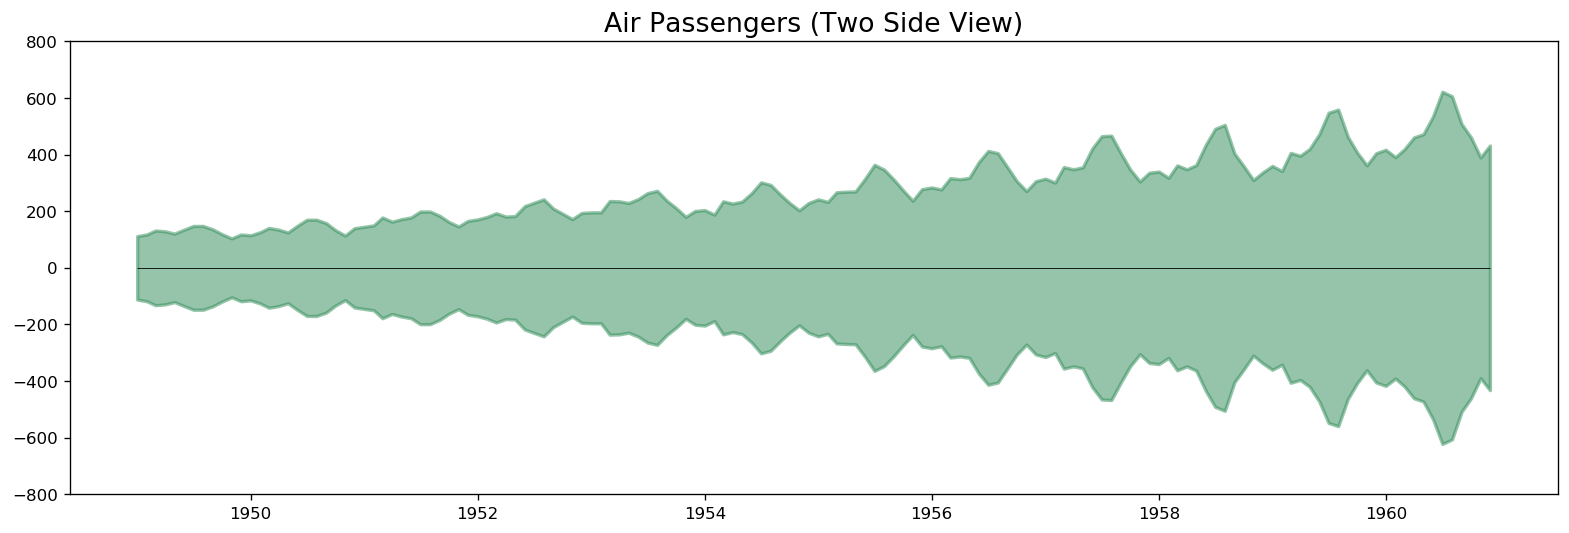

In [9]:
# Visualize Air Passengers Time Series
# Plot
x = air_pass['date'].values
y1 = air_pass['value'].values

fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-800, 800)
plt.title('Air Passengers (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(air_pass.date), xmax=np.max(air_pass.date), linewidth=.5)
plt.show()


## Missing Values

Sometimes, your time series will have missing dates/times. That means, the data was not captured or was not available for those periods. It could so happen the measurement was zero on those days, in which case, case you may fill up those periods with zero.

Secondly, when it comes to time series, you should typically NOT replace missing values with the mean of the series, especially if the series is not stationary. What you could do instead for a quick and dirty workaround is to forward-fill the previous value.

However, depending on the nature of the series, you want to try out multiple approaches before concluding. Some effective alternatives to imputation are:

1. Actual data
1. Forward Fill
1. Backward Fill
1. Linear Interpolation
1. Quadratic interpolation
1. Mean of nearest neighbors
1. Mean of seasonal couterparts


To measure the imputation performance, I manually introduce missing values to the time series, impute it with above approaches and then measure the mean squared error of the imputed against the actual values.

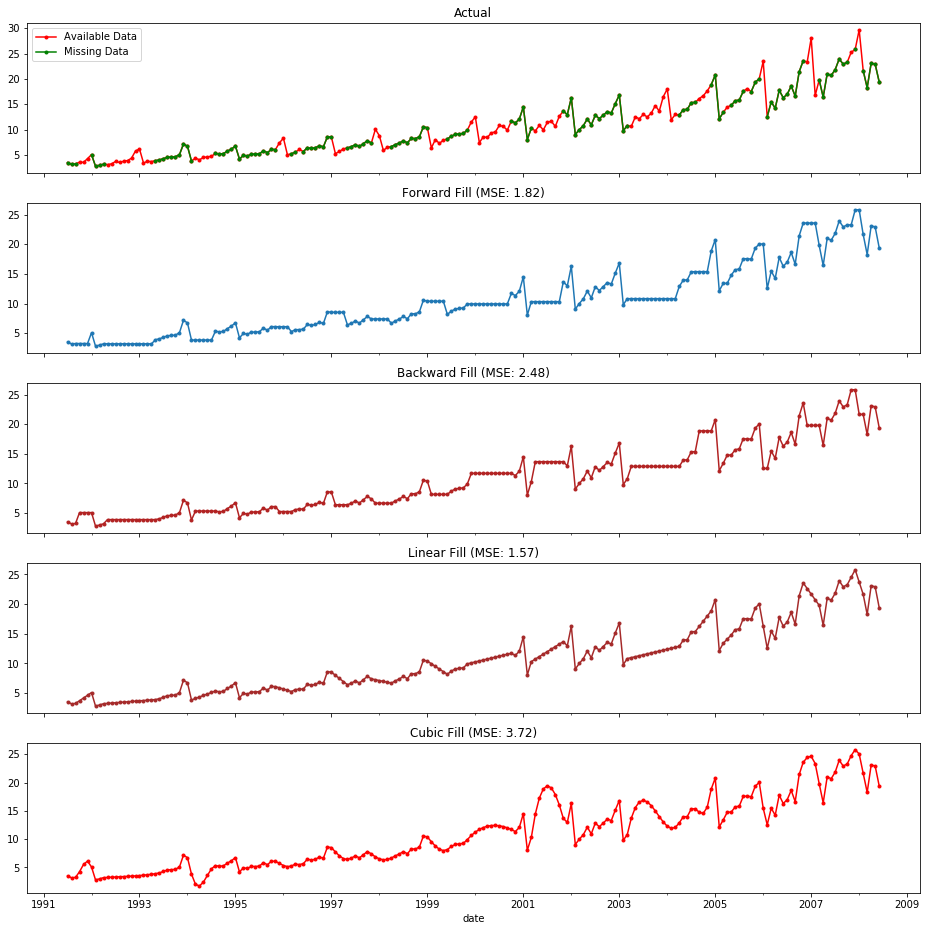

In [10]:
## DEFINE THE PLOT

fig, axes = plt.subplots(5, 1, sharex=True, figsize=(16, 16))
plt.rcParams.update({'xtick.bottom' : False})


## 1. ACTUAL DATA

df.value.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df_missing.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Available Data","Missing Data"])

## 2. FORWARD FILL (CLASSIC)

df_ffill = df_missing.ffill()

error = np.round(metrics.mean_squared_error(df['value'], df_ffill['value']), 2)

df_ffill['value'].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")


## 3. BACKWARD FILL (CLASSIC)

df_bfill = df_missing.bfill()

error = np.round(metrics.mean_squared_error(df['value'], df_bfill['value']), 2)

df_bfill['value'].plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")


## 4. LINEAR INTERPOLATION
df_linear = df_missing.copy()

df_linear['rownum'] = np.arange(df_linear.shape[0])

df_nona = df_linear.dropna(subset = ['value'])

f = interpolate.interp1d(df_nona['rownum'], df_nona['value'])

df_linear['linear_fill'] = f(df_linear['rownum'])
error = np.round(metrics.mean_squared_error(df['value'], df_linear['linear_fill']), 2)

df_linear['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")", ax=axes[3], label='Cubic Fill', color='brown', style=".-")



## 5. CUBIC INTERPOLATION
df_cubic = df_missing.copy()

f2 = interpolate.interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')

df_cubic['cubic_fill'] = f2(df_linear['rownum'])

error = np.round(metrics.mean_squared_error(df['value'], df_cubic['cubic_fill']), 2)

df_cubic['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) +")", ax=axes[4], label='Cubic Fill', color='red', style=".-")



In [11]:
# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

You could also consider the following approaches depending on how accurate you want the imputations to be.

- If you have explanatory variables use a prediction model like the random forest or k-Nearest Neighbors to predict it.
- If you have enough past observations, forecast the missing values.
- If you have enough future observations, backcast the missing values
- Forecast of counterparts from previous cycles.


## Sampling frequency, Gaps and Outliers

Necessary and indispensable moment in the analysis of time series.  
This step is important to check the sampling frequency of a data set and to verify the gaps

In [12]:
df.index

DatetimeIndex(['1991-07-01', '1991-08-01', '1991-09-01', '1991-10-01',
               '1991-11-01', '1991-12-01', '1992-01-01', '1992-02-01',
               '1992-03-01', '1992-04-01',
               ...
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01'],
              dtype='datetime64[ns]', name='date', length=204, freq=None)

In [13]:
result_gaps = find_timegaps(df_missing.index,'30 days',gap_comparison='equal',divergent_only=True)
print('Result Gaps:',result_gaps.head())
print(f'\nShape: {result_gaps.shape}')

Result Gaps:     timestamp  mask   delta
3  1991-10-01  True 30 days
5  1991-12-01  True 30 days
10 1992-05-01  True 30 days
12 1992-07-01  True 30 days
15 1992-10-01  True 30 days

Shape: (67, 3)


Time delta used for the function: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timedelta.html

You have to pay attention to the default sampling rate, to verify it you can do it:

In [14]:
pd.infer_freq(df.index)

'MS'

Documentation about frequencies: https://pandas.pydata.org/docs/user_guide/timeseries.html#dateoffset-objects

### Plot the distribution of Data

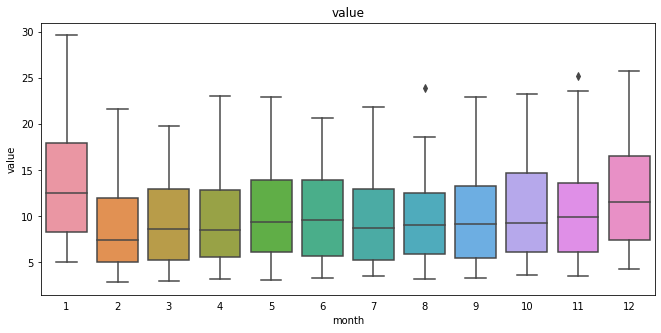

In [15]:
plot_interval(df,['value'],'month')

-----------------------

## LAG

A “lag” is a fixed amount of passing time; One set of observations in a time series is plotted (lagged) against a second, later set of data. The kth lag is the time period that happened “k” time points before time i. For example:
Lag1(Y2) = Y1 and Lag4(Y9) = Y5.
The most commonly used lag is 1, called a first-order lag plot.

Plots with a single plotted lag are the most common. However, it is possible to create a lag plot with multiple lags with separate groups (typically different colors) representing each lag.

Lag plots allow you to check for:

- Model suitability.
- Outliers (data points with extremely high or low values).
- Randomness (data without a pattern).
- Serial correlation (where error terms in a time series transfer from one period to another).
- Seasonality (periodic fluctuations in time series data that happens at regular periods).

If you want some informations about lag plot you can follow this examples: https://www.statisticshowto.com/lag-plot/

Before you can apply machine learning models to time series data, you have to transform it to an “ingestible” format for your models, and this often involves calculating lagged variables, which can measure auto-correlation i.e. how past values of a variable influence its future values, thus unlocking predictive value

Below are 3 different approaches I have used recently to generate lagged variables in Pandas:
1. Lag one or more variables across one group — using shift method
2. Lag one variable across multiple groups — using unstack method
3. Lag multiple variables across multiple groups — with groupby


In [25]:
##GENERATE SET OF DATA TO LAG
np.random.seed(0) # ensures the same set of random numbers are generated
date = ['2019-01-01']*3 + ['2019-01-02']*3 + ['2019-01-03']*3
var1, var2 = np.random.randn(9), np.random.randn(9)*20 
group = ["group1", "group2", "group3"]*3 # to assign the groups for the multiple group case

df_manygrp = pd.DataFrame({"date": date, "group":group, "var1": var1}) # one var, many groups
df_combo = pd.DataFrame({"date": date, "group":group, "var1": var1, "var2": var2}) # many vars, many groups
df_onegrp = df_manygrp[df_manygrp["group"]=="group1"] # one var, one group

for d in [df_onegrp, df_manygrp, df_combo]: # loop to apply the change to both dfs
    d["date"] = pd.to_datetime(d['date'])
    print("Column changed to: ", d.date.dtype.name)

    
print(f'Manygrp: {df_manygrp.shape}')
print(f'Combo: {df_combo.shape}')
print(f'OneGrp: {df_onegrp.shape}')
print('\n',df_manygrp.head())
print('\n',df_combo.head())
print('\n',df_onegrp.head())

Column changed to:  datetime64[ns]
Column changed to:  datetime64[ns]
Column changed to:  datetime64[ns]
Manygrp: (9, 3)
Combo: (9, 4)
OneGrp: (3, 3)

         date   group      var1
0 2019-01-01  group1  1.764052
1 2019-01-01  group2  0.400157
2 2019-01-01  group3  0.978738
3 2019-01-02  group1  2.240893
4 2019-01-02  group2  1.867558

         date   group      var1       var2
0 2019-01-01  group1  1.764052   8.211970
1 2019-01-01  group2  0.400157   2.880871
2 2019-01-01  group3  0.978738  29.085470
3 2019-01-02  group1  2.240893  15.220755
4 2019-01-02  group2  1.867558   2.433500

         date   group      var1
0 2019-01-01  group1  1.764052
3 2019-01-02  group1  2.240893
6 2019-01-03  group1  0.950088


ts.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  one.


1. **Lag one or more variables across one group/category — using “shift” method**

Here, we simply use the shift method available to the dataframe and specify the number of steps (in our case, its 1 “day”) to lag after we set the date column as an index. Remember you can also use a negative number as the shift, which would mean that future values are influencing the past

In [26]:
df_onegrp

,date,group,var1
0,2019-01-01,group1,1.764052
3,2019-01-02,group1,2.240893
6,2019-01-03,group1,0.950088


In [27]:
df_onegrp.set_index(["date"]).shift(1)

,group,var1
date,,
2019-01-01,NaN,NaN
2019-01-02,group1,1.764052
2019-01-03,group1,2.240893


2. **Lag one variable across multiple groups — using “unstack” method**

Overall, we should be aware that we want to index the data first, then unstack to separate the groups before applying the lag function. Failure to do this will actually do the wrong thing to your data. 

For example, it may shift the last value of the previous group onto the first value of the next group, thus mixing data across groups. Imagine if the groups were states and the variable was population over time in years. If you make such a mistake, it will be like assuming that the population of Pennsylvania in its latter years, influences that of Rhode Island in its earlier years because these states are next to each other, alphabetically. Which makes no sense.  
This can be a huge pitfall and will lead to completely wrong analysis.

So, set the index to be your dates and groups. Then pull out the groups using unstack and then shift the columns just like in the previous approach. 

A Lag plot is a scatter plot of a time series against a lag of itself. It is normally used to check for autocorrelation. If there is any pattern existing in the series like the one you see below, the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise.

In below example on Sunspots area time series, the plots get more and more scattered as the n_lag increases.

In [28]:
df_manygrp

,date,group,var1
0,2019-01-01,group1,1.764052
1,2019-01-01,group2,0.400157
2,2019-01-01,group3,0.978738
3,2019-01-02,group1,2.240893
4,2019-01-02,group2,1.867558
5,2019-01-02,group3,-0.977278
6,2019-01-03,group1,0.950088
7,2019-01-03,group2,-0.151357
8,2019-01-03,group3,-0.103219


In [29]:
df_mlt = df_manygrp.set_index(["date", "group"]) # index
df_mlt = df.unstack().shift(1)          # pull out the groups, shift with lag step=1
df_mlt = df.stack(dropna=False);df       # stack the groups back, keep the missing values

#Rearrange index data
df_mlt.reset_index().sort_values("group")

KeyError: 'group'

3. **Lag multiple variables distributed across multiple groups, simultaneously — using “groupby” method**

The key steps are grouping the data using the “group” column; making a function that sorts, indexes on date and shifts the data in each group, then iterating over the groupby object to apply the function to each group. Finally, we use handy list comprehension and then concatenate this list back to its original format.

Key Concepts:

- Assign: I recently discovered the assign method available to dataframes. It cleans up your code, allowing you to generate a new column and assign new values to it without having to use an intermediate dataframe. It automatically returns a copy of the data.
- Method-chaining: The function also uses parenthesis in the return statement in order to allow method chaining, another way to write clean, legible code.

In [31]:
# Group the data
grouped_df = df_combo.groupby(["group"])

In [32]:
# Make Function with assign and method-chaining:
def lag_by_group(key, value_df):
    df = value_df.assign(group = key) # this pandas method returns a copy of the df, with group columns assigned the key value
    return (df.sort_values(by=["date"], ascending=True)
        .set_index(["date"])
        .shift(1)
               ) # the parenthesis allow you to chain methods and avoid intermediate variable assignment

In [33]:
# Apply function to each group using list comprehension then concatenate vertically:
dflist = [lag_by_group(g, grouped_df.get_group(g)) for g in grouped_df.groups.keys()]
pd.concat(dflist, axis=0).reset_index()

,date,group,var1,var2
0,2019-01-01,NaN,NaN,NaN
1,2019-01-02,group1,1.764052,8.211970
2,2019-01-03,group1,2.240893,15.220755
3,2019-01-01,NaN,NaN,NaN
4,2019-01-02,group2,0.400157,2.880871
5,2019-01-03,group2,1.867558,2.433500
6,2019-01-01,NaN,NaN,NaN
7,2019-01-02,group3,0.978738,29.085470
8,2019-01-03,group3,-0.977278,8.877265


In below example on Sunspots area time series, the plots get more and more scattered as the n_lag increases.

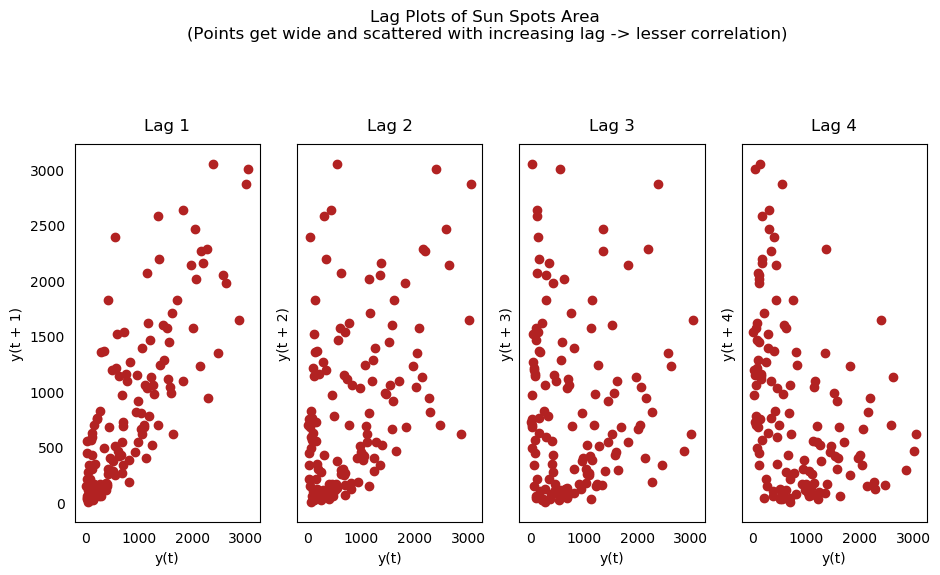

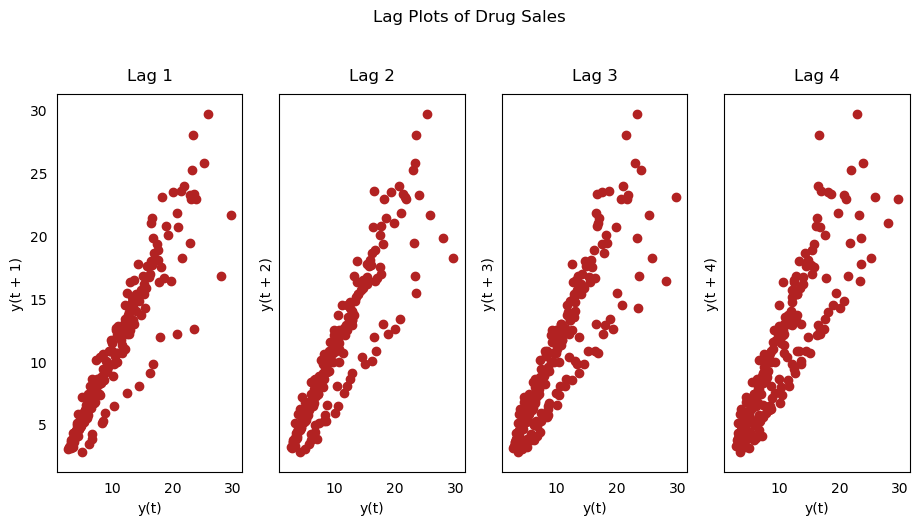

In [34]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Import
ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')


# Plot
fig, axes = plt.subplots(1, 4, figsize=(11,5), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(ss.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Sun Spots Area \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

fig, axes = plt.subplots(1, 4, figsize=(11,5), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df_drugs.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Drug Sales', y=1.05)    
plt.show()

-----------

## Autocorrelation

**Autocorrelation** is simply the correlation of a series with its own lags.   

If a series is significantly autocorrelated, that means, **the previous values of the series (lags) may be helpful in predicting the current value.**

Autocorrelation **measures a set of current values against a set of past values to see if they correlate.** It is heavily used in time series analysis and forecasting.  

We can calculate the correlation for current time-series observations with observations of previous time steps called lags.

A plot of the autocorrelation of a time series is called the Autocorrelation Function (ACF).

**Partial Autocorrelation** also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

So we have our function:

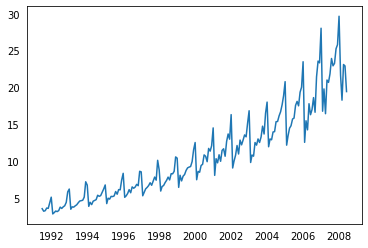

In [35]:
plt.plot(df.index, df.values)

Try to observe the autocorrelation

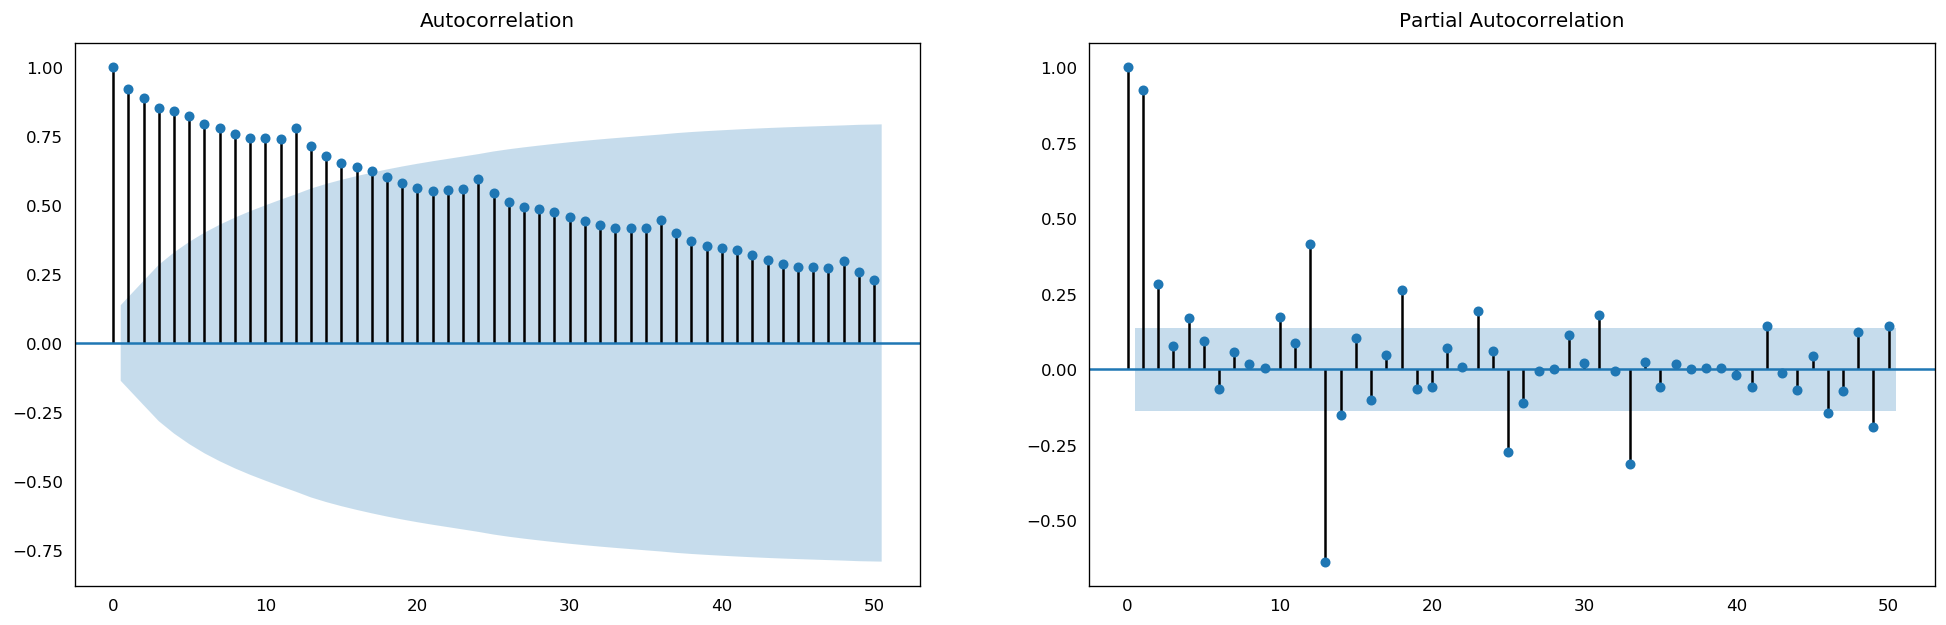

In [36]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(20,6), dpi= 120)
plot_acf(df.value.tolist(), lags=50, ax=axes[0])
plot_pacf(df.value.tolist(), lags=50, ax=axes[1])
plt.show()

An example autocorrelation plot. Sharp peaks indicate a sharp correlation in time series, whereas shorter peaks indicate little correlation in the time series.

Autocorrelation plots graphically summarize the relationship between an observation in a time series and an observation at a prior time.

To understand better why Autocorrelation is important, you can see also this links:  
- https://dzone.com/articles/autocorrelation-in-time-series-data
- https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/

---------------

## Check Seasonality


In [500]:
# Prepare data

df_drugs['year'] = [d.year for d in df_drugs.date]
df_drugs['month'] = [d.strftime('%b') for d in df_drugs.date]
years = df_drugs['year'].unique()

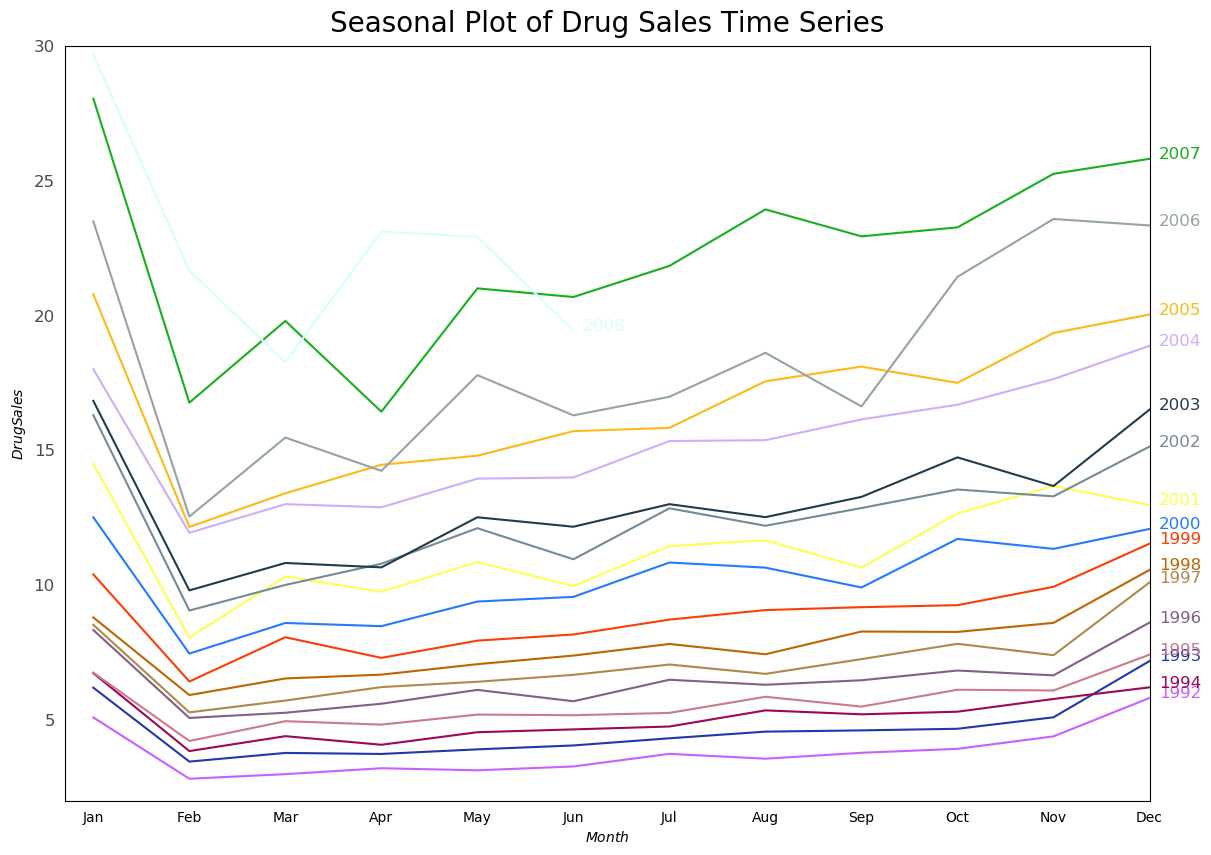

In [443]:
# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(14,10), dpi= 100)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=df_drugs.loc[df_drugs.year==y, :], color=mycolors[i], label=y)
        plt.text(df_drugs.loc[df_drugs.year==y, :].shape[0]-.9, df_drugs.loc[df_drugs.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
plt.show()

There is a steep fall in drug sales every February, rising again in March, falling again in April and so on. Clearly, the pattern repeats within a given year, every year.

However, as years progress, the drug sales increase overall. You can nicely visualize this trend and how it varies each year in a nice year-wise boxplot. Likewise, you can do a month-wise boxplot to visualize the monthly distributions.

### Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution

You can group the data at seasonal intervals and see how the values are distributed within a given year or month and how it compares over time.

So we can consider the trend as = trend over the years (grouping)  

Seasonality = trend in the various months, for all years (grouping)

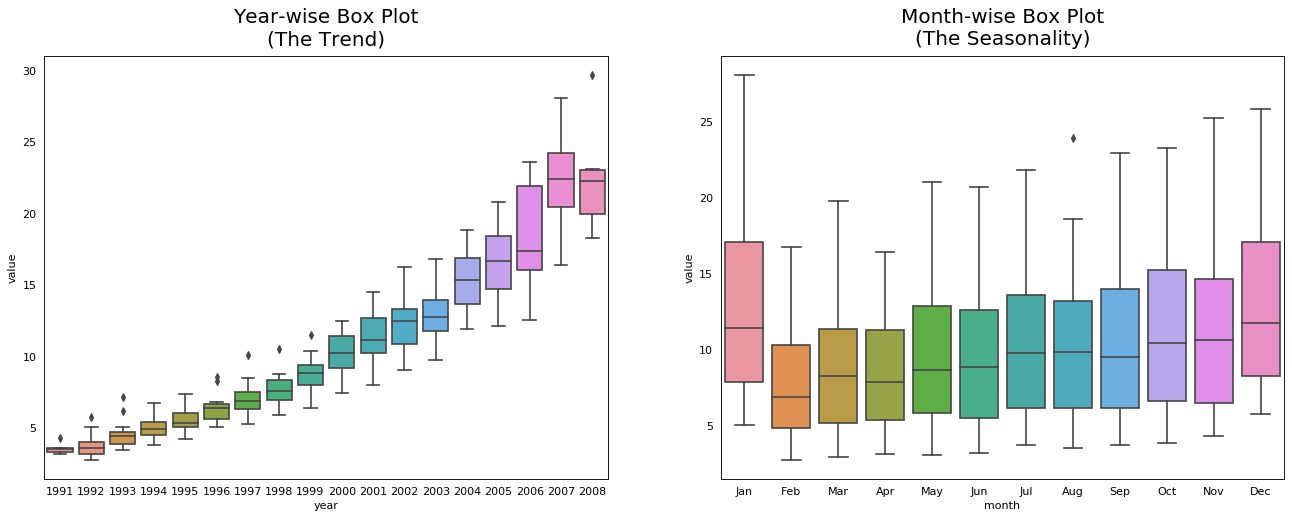

In [444]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df_drugs, ax=axes[0])
sns.boxplot(x='month', y='value', data=df_drugs.loc[~df_drugs.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

The boxplots make the year-wise and month-wise distributions evident. Also, in a month-wise boxplot, the months of December and January clearly has higher drug sales, which can be attributed to the holiday discounts season.

Another way to verify this information is to use a decomposition

In [445]:
from pylab import rcParams
import statsmodels.api as sm

In [446]:
# Modify the data
y = df_drugs.copy()
y.index = y['date']
y = y.drop(['date','year','month'],axis=1)

This method is very convenient because it is able to automatically infer the parameters of the time series

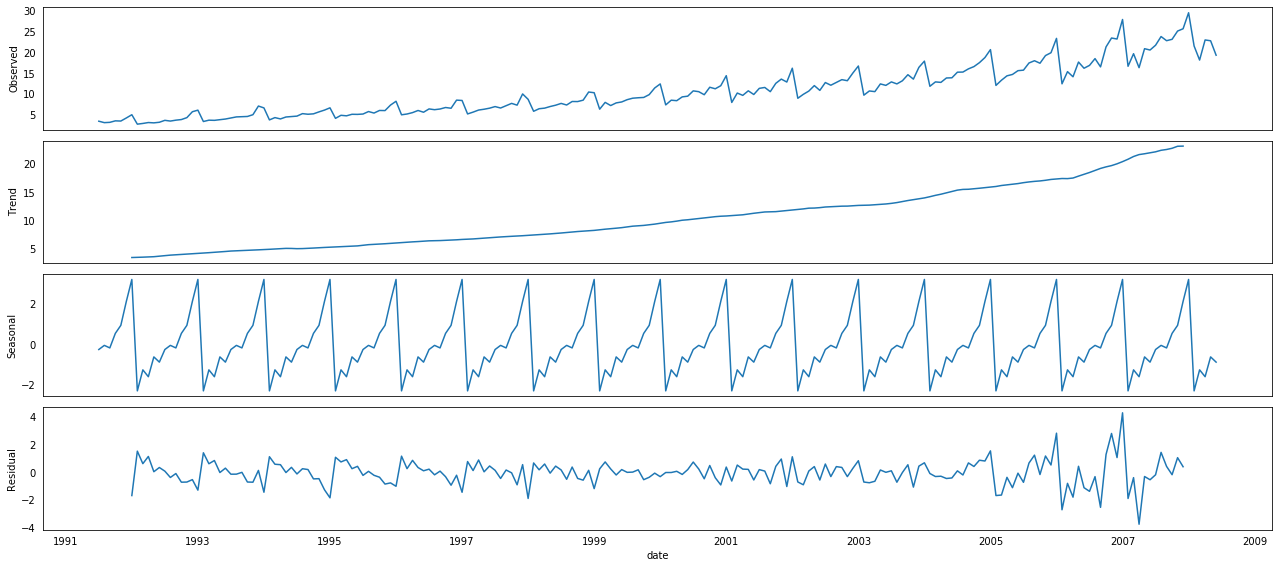

In [447]:
#Decompose the serie
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

So far, we have seen the similarities to identify the pattern. Now, how to find out any deviations from the usual pattern?

## Patterns in a time series

Any time series may be split into the following components: **Base Level + Trend + Seasonality + Error**

A trend is observed when there is an increasing or decreasing slope observed in the time series. Whereas seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day.

However, It is not mandatory that all time series must have a trend and/or seasonality. A time series may not have a distinct trend but have a seasonality. The opposite can also be true.

So, a time series may be imagined as a combination of the trend, seasonality and the error terms.

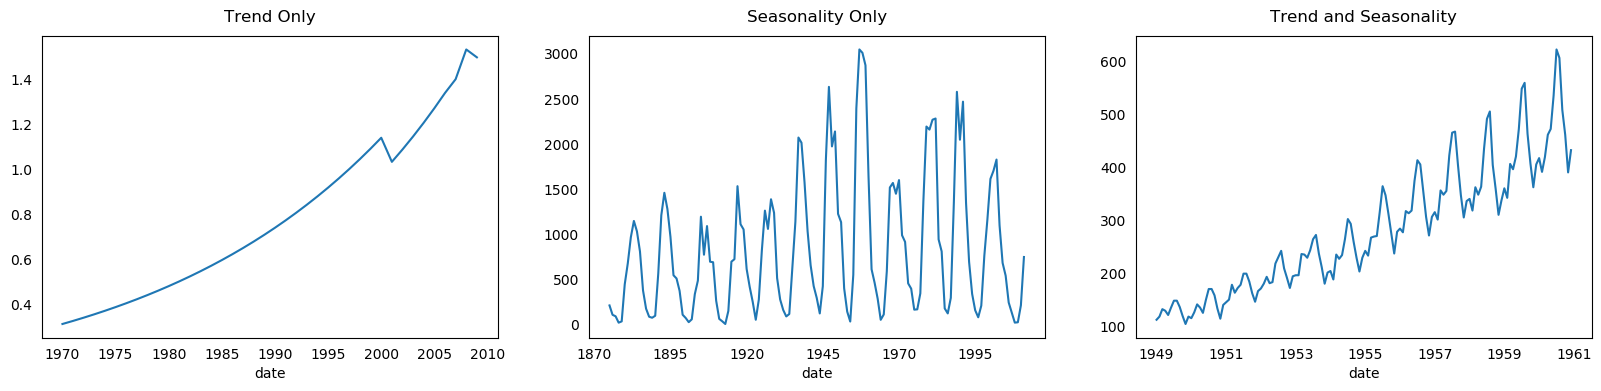

In [448]:
fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])

Another aspect to consider is the cyclic behaviour. It happens when the rise and fall pattern in the series does not happen in fixed calendar-based intervals. Care should be taken to not confuse ‘cyclic’ effect with ‘seasonal’ effect.

So, How to diffentiate between a ‘cyclic’ vs ‘seasonal’ pattern?

If the patterns are not of fixed calendar based frequencies, then it is cyclic. Because, unlike the seasonality, cyclic effects are typically influenced by the business and other socio-economic factors.

### Additive or Multiplicative Patterns

Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or multiplicative, wherein, each observation in the series can be expressed as either a sum or a product of the components:

**Additive time series**:
Value = Base Level + Trend + Seasonality + Error

**Multiplicative Time Series**:
Value = Base Level x Trend x Seasonality x Error

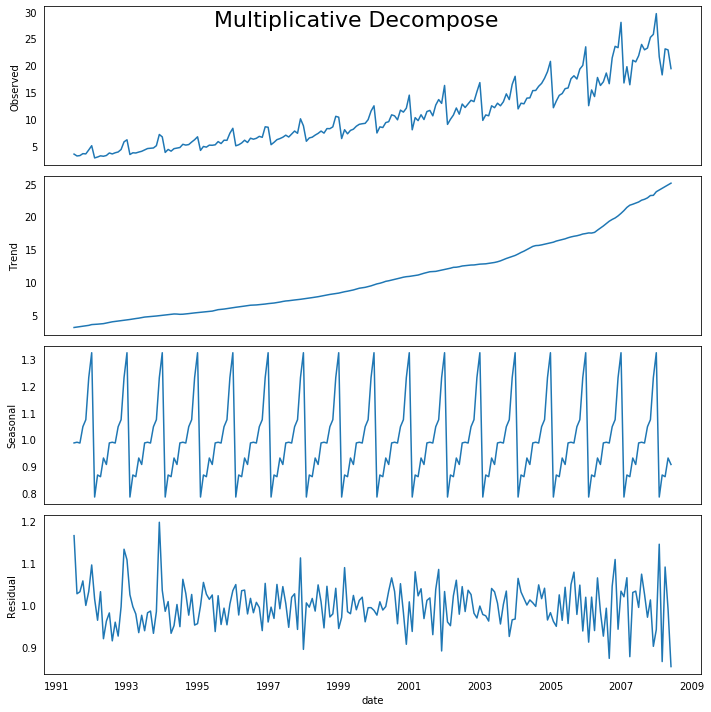

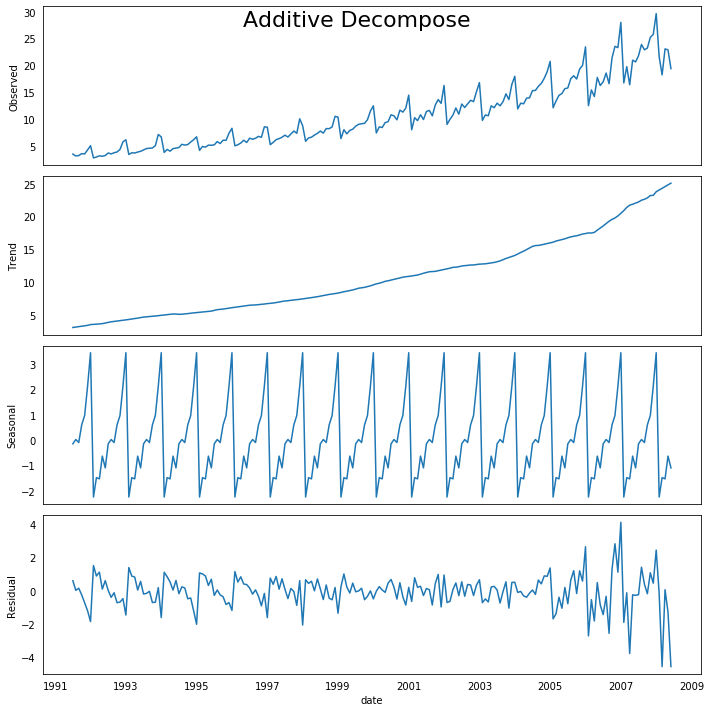

In [449]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
result_mul = seasonal_decompose(y['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(y['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

Which to choose between the two series represented here? 

Setting extrapolate_trend='freq' takes care of any missing values in the trend and residuals at the beginning of the series.
I missing value vengono anche chiamati all'interno delle serie temporali: GAP

If you look at the residuals of the additive decomposition closely, it has some pattern left over (stagionality).
The multiplicative decomposition, however, looks quite random which is good. So ideally, multiplicative decomposition should be preferred for this particular series.

So the best decomposition is multiplication and you can use it to set patterns.

The numerical output of the trend, seasonal and residual components are stored in the result_mul output itself. Let’s extract them and put it in a dataframe.

In [450]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
print(df_reconstructed.head())
print(df_reconstructed.tail())

                seas     trend     resid  actual_values
date                                                   
1991-07-01  0.987845  3.060085  1.166629       3.526591
1991-08-01  0.990481  3.124765  1.027745       3.180891
1991-09-01  0.987476  3.189445  1.032615       3.252221
1991-10-01  1.048329  3.254125  1.058513       3.611003
1991-11-01  1.074527  3.318805  0.999923       3.565869
                seas      trend     resid  actual_values
date                                                    
2008-02-01  0.785976  24.037399  1.146165      21.654285
2008-03-01  0.868249  24.298458  0.865756      18.264945
2008-04-01  0.861883  24.559516  1.091662      23.107677
2008-05-01  0.931613  24.820574  0.990890      22.912510
2008-06-01  0.907423  25.081633  0.853780      19.431740


If you check, the product of seas, trend and resid columns should exactly equal to the actual_values.

## Stationarity vs. Non-Stationarity

Stationarity is a significant property of a time series.  

A stationary series is one where the values of the series is not a function of time.

That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time.  
Autocorrelation of the series is nothing but the correlation of the series with its previous values, more on this coming up.

A stationary time series id devoid of seasonal effects as well.

So how to identify if a series is stationary or not? Let’s plot some examples to make it clear

![Stationary Time Series](stationary-ts.png)

So why does a stationary series matter? why am I even talking about it?

I will come to that in a bit, but understand that it is possible to make nearly any time series stationary by applying a suitable transformation.  
Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary.

## Test the stationarity

So how to test a time series for stationarity?

A TS is said to be **stationary if its statistical properties such as mean, variance remain constant over time**

In the most intuitive sense, **stationarity means that the statistical properties of a process generating a time series do not change over time**
It does not mean that the series does not change over time, just that the way it changes does not itself change over time

But why is it important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future.  
Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

If you want more informations:  
https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322  
https://machinelearningmastery.com/time-series-data-stationary-python/

Stationarity is defined using very strict criterion.  
However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:
- constant mean
- constant variance
- an autocovariance that does not depend on time.

So as an example let's consider this series that we analyzed and uploaded previously

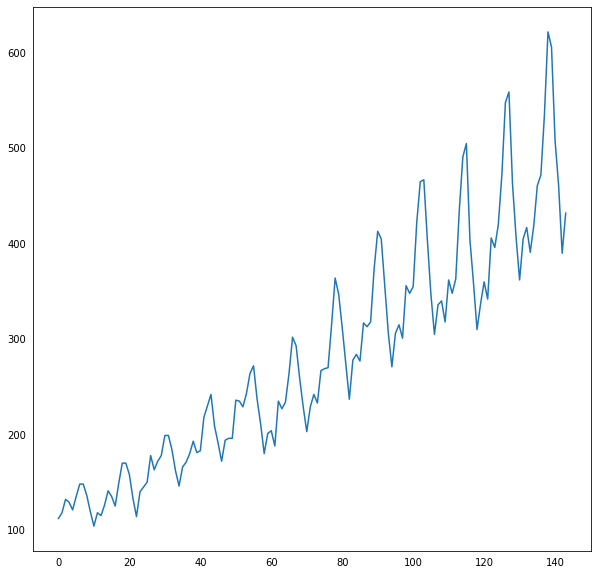

In [502]:
x = air_pass['date'].values
y1 = air_pass['value'].values
plt.plot(y1)

It is clearly evident that there is an **overall increasing trend** in the data along with some seasonal variations.

However, it might not always be possible to make such visual inferences (we’ll see such cases later).

We therefore need a more formal and statistical method to verify the stationarity of our series, so we could apply one of the following methods:

1. **Plotting Rolling Statistics**: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

2. **Dickey-Fuller Test**: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

If you want more detail about Dickey-Fuller Test you can check this article (sorry it's in R): \
https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

In [452]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    """
    Check Stationariety of time series.
    Please use np.array or pd.series as Input with your TS data only
    """
    #Convert numpy array to pandas serie
    if type(timeseries) is np.ndarray:
        df_timeseries = pd.Series(timeseries) 
        
    try:
        #Determing rolling statistics
        rolmean = df_timeseries.rolling(window=12).mean()
        rolstd = df_timeseries.rolling(window=12).std()

        #Plot rolling statistics:
        orig = plt.plot(timeseries, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)

        #Perform Dickey-Fuller test:
        print('Results of Dickey-Fuller Test:')

        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        
        # print(dfoutput)
    
        return dftest, dfoutput
    except Exception as message:
        print(f"Impossible to calc the stationariery of your TS: {message}")
        return None, None

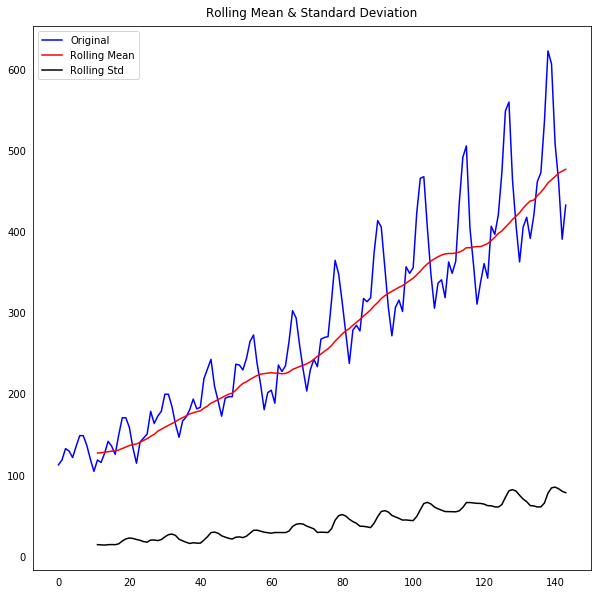

Results of Dickey-Fuller Test:


Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

In [453]:
dftest, dfoutput = test_stationarity(y1)
dfoutput

Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series.

Also, the test statistic is way more than the critical values.

Note that the signed values should be compared and not the absolute values.

Next, we’ll discuss the techniques that can be used to take this TS towards stationarity.

#### White Noise

You have to be careful with time series because it can happen to have data containing noise, especially when working with sensors.  
Like a stationary series, the white noise is also not a function of time, that is its mean and variance does not change over time. But the difference is, the white noise is completely random with a mean of 0.

In white noise there is no pattern whatsoever. If you consider the sound signals in an FM radio as a time series, the blank sound you hear between the channels is white noise.

Mathematically, a sequence of completely random numbers with mean zero is a white noise.

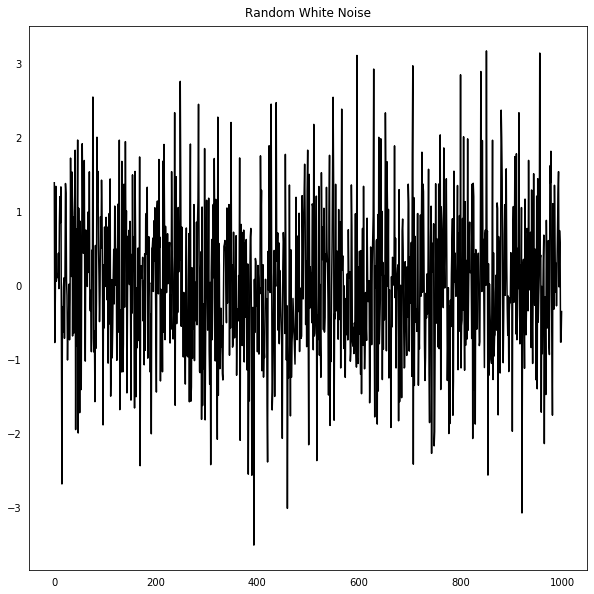

In [454]:
randvals = np.random.randn(1000)
pd.Series(randvals).plot(title='Random White Noise', color='k')

-------------------------------

## Detrend a Time Series

Detrending a time series is to remove the trend component from a time series. But how to extract the trend? There are multiple approaches.

Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms (x^2) in the model.

- Subtract the mean
- Subtract the trend component obtained from time series decomposition we saw earlier.
- Apply some special and advanced filters (like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components)

Let’s implement the first two methods.

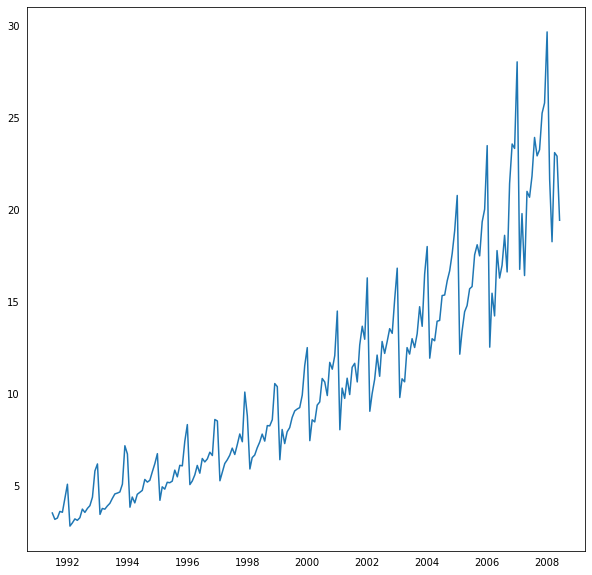

In [455]:
#This is our TS
df_detrend = df_drugs.copy()
df_detrend.index = df_detrend.date
df_detrend = df_detrend.drop('date',axis=1)
plt.plot(df_detrend.index, df_detrend.value)

In [456]:
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the least squares fit')

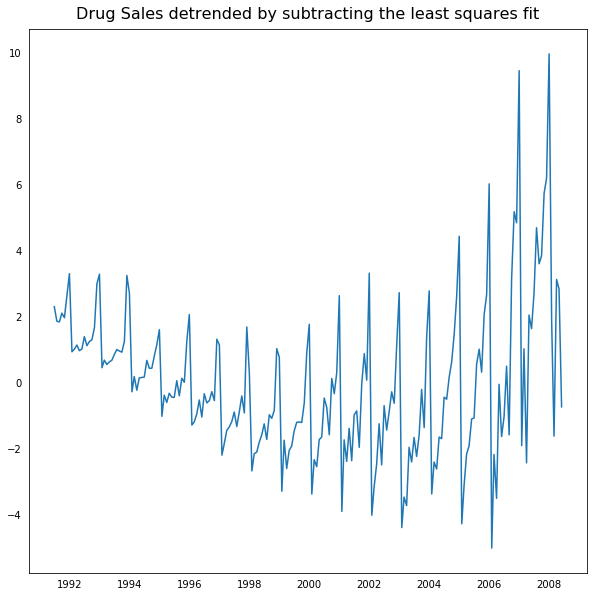

In [457]:
# Using scipy: Subtract the line of best fit

detrended = signal.detrend(df_detrend.value.values)
plt.plot(df_detrend.index, detrended)
plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=16)

The second method is quite robust and use a multiplicative model for decomposition

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the trend component (multiplicative)')

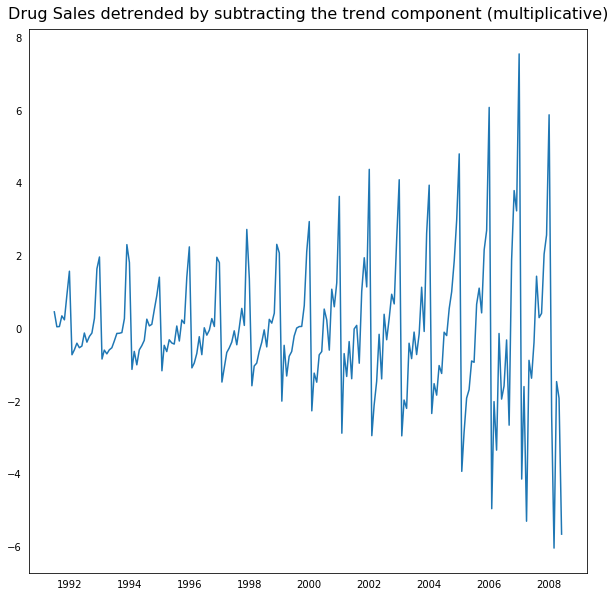

In [458]:
# Using statmodels: Subtracting the Trend Component.

result_mul = seasonal_decompose(df_detrend['value'], model='multiplicative', extrapolate_trend='freq')
detrended = df_detrend.value.values - result_mul.trend
plt.plot(df_detrend.index, detrended)
plt.title('Drug Sales detrended by subtracting the trend component (multiplicative)', fontsize=16)

Let's see what happend with an additive decomposition

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the trend component (additive)')

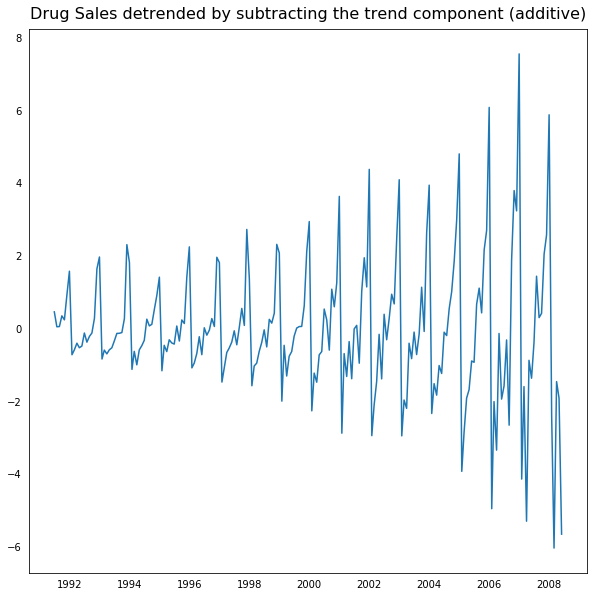

In [459]:
# Using statmodels: Subtracting the Trend Component.

result_mul = seasonal_decompose(df_detrend['value'], model='additive', extrapolate_trend='freq')
detrended = df_detrend.value.values - result_mul.trend
plt.plot(df_detrend.index, detrended)
plt.title('Drug Sales detrended by subtracting the trend component (additive)', fontsize=16)

## Deseasonalize

There are multiple approaches to deseasonalize a time series as well.

Here some examples

- 1. Take a moving average with length as the seasonal window. This will smoothen in series in the process.
- 2. Seasonal difference the series (subtract the value of previous season from the current value)
- 3. Divide the series by the seasonal index obtained from STL decomposition

If dividing by the seasonal index does not work well, try taking a log of the series and then do the deseasonalizing. You can later restore to the original scale by taking an exponential.

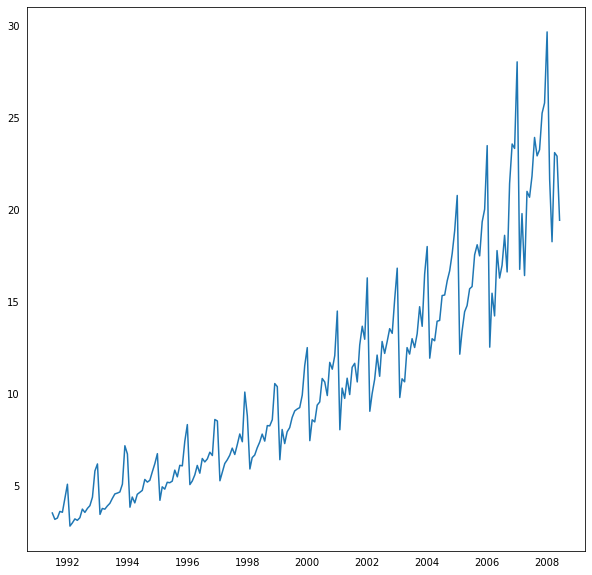

In [504]:
plt.plot(df_detrend.value)

[]

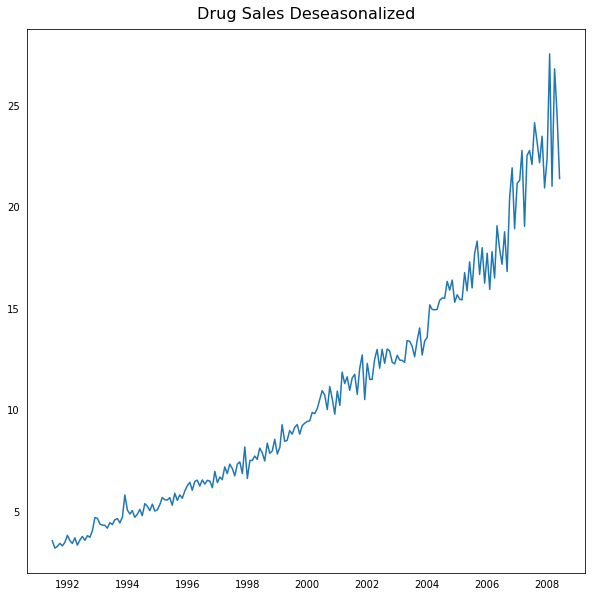

In [460]:
# Subtracting the Trend Component.
df_deseason = df_detrend.copy()

# Time Series Decomposition
result_mul = seasonal_decompose(df_deseason['value'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df_deseason.value.values / result_mul.seasonal

# Plot
plt.plot(df_deseason.index, deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16)
plt.plot()

## Smoote a Time Series

Smoothening of a time series may be useful in:

- Reducing the effect of noise in a signal get a fair approximation of the noise-filtered series.
- The smoothed version of series can be used as a feature to explain the original series itself.
- Visualize the underlying trend better

So how to smoothen a series? Let’s discuss the following methods:

- Take a moving average
- Do a LOESS smoothing (Localized Regression)
- Do a LOWESS smoothing (Locally Weighted Regression)

Moving average is nothing but the average of a rolling window of defined width. But you must choose the window-width wisely, because, large window-size will over-smooth the series. For example, a window-size equal to the seasonal duration (ex: 12 for a month-wise series), will effectively nullify the seasonal effect.

LOESS, short for ‘LOcalized regrESSion’ fits multiple regressions in the local neighborhood of each point. It is implemented in the statsmodels package, where you can control the degree of smoothing using frac argument which specifies the percentage of data points nearby that should be considered to fit a regression model.

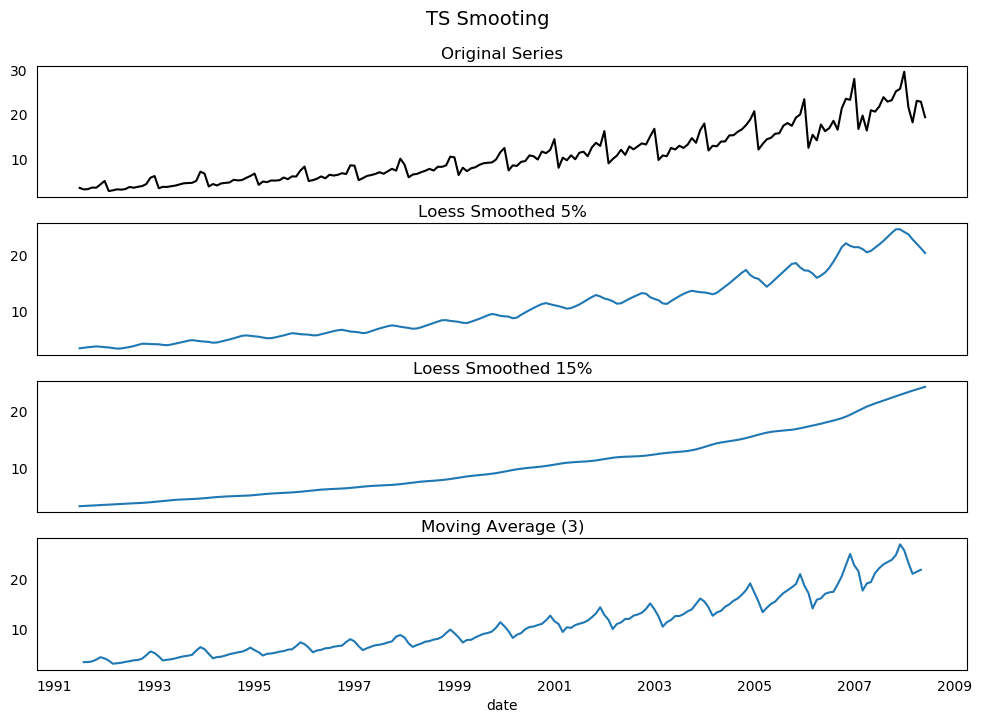

In [461]:
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# Import
df_smoote = df.copy()

# 1. Moving Average
df_ma = df_smoote.value.rolling(3, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df_smoote.value, np.arange(len(df_smoote.value)), frac=0.05)[:, 1], index=df_smoote.index, columns=['value'])
df_loess_15 = pd.DataFrame(lowess(df_smoote.value, np.arange(len(df_smoote.value)), frac=0.15)[:, 1], index=df_smoote.index, columns=['value'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(12, 8), sharex=True, dpi=100)
df_smoote['value'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['value'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['value'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('TS Smooting', y=0.95, fontsize=14)
plt.show()

----------

# Forecasting a Time Series
Traditional Statistics Methods

For details: https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

### Verify Forecastability of a Time Serie

The more regular and repeatable patterns a time series has, the easier it is to forecast. The ‘Approximate Entropy’ can be used to quantify the regularity and unpredictability of fluctuations in a time series.

The higher the approximate entropy, the more difficult it is to forecast it.

Another better alternate is the ‘Sample Entropy’.

Sample Entropy is similar to approximate entropy but is more consistent in estimating the complexity even for smaller time series. For example, a random time series with fewer data points can have a lower ‘approximate entropy’ than a more ‘regular’ time series, whereas, a longer random time series will have a higher ‘approximate entropy’.

Sample Entropy handles this problem nicely. See the demonstration below.

In [462]:
# https://en.wikipedia.org/wiki/Approximate_entropy

rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(f'Dataset ss: {ApEn(ss.value, m=2, r=0.2*np.std(ss.value))}')     # 0.651
print(f'Dataset df: {ApEn(df.value, m=2, r=0.2*np.std(df.value))}')   # 0.537
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small))) # 0.143
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big)))     # 0.716

Dataset ss: 0.6514704970333534
Dataset df: 0.5374775224973489
0.0898376940798844
0.6725953850207098


In [505]:
# https://en.wikipedia.org/wiki/Sample_entropy

rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(ss.value, m=2, r=0.2*np.std(ss.value)))      # 0.78
print(SampEn(df.value, m=2, r=0.2*np.std(df.value)))    # 0.41
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  # 1.79
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))      # 2.42

0.7853311366380039
0.41887013457621214
inf
2.001480000210124


ts.py:17: RuntimeWarning: divide by zero encountered in log
  Series that represents a dataframe index, populated by timestamps.


## BONUS: Time as a Feature

Time in time series can also be interpreted as a feature for some models. Not just as a Time series.

This completely changes the analysis and considers time as a categorical feature.

You need to interpret it in the correct way to use it as a feature.  
In these cases, you divide a date into its components and then apply transformations.

This is one of the most common mistakes that you make when working with time   
https://medium.com/ai³-theory-practice-business/top-6-errors-novice-machine-learning-engineers-make-e82273d394db

So let's consider our dataset and see how to decompose the date to use it as a feature

In [506]:
complete_date = df.index
month = pd.DatetimeIndex(complete_date).month
year = pd.DatetimeIndex(complete_date).year

df_features = df.copy()
df_features = df_features.reset_index()
df_features['month'] = month
df_features['year'] = year
df_features = df_features.drop('date',axis=1)
df_features.head()

,value,month,year
0,3.526591,7,1991
1,3.180891,8,1991
2,3.252221,9,1991
3,3.611003,10,1991
4,3.565869,11,1991


If we plot the time we get...

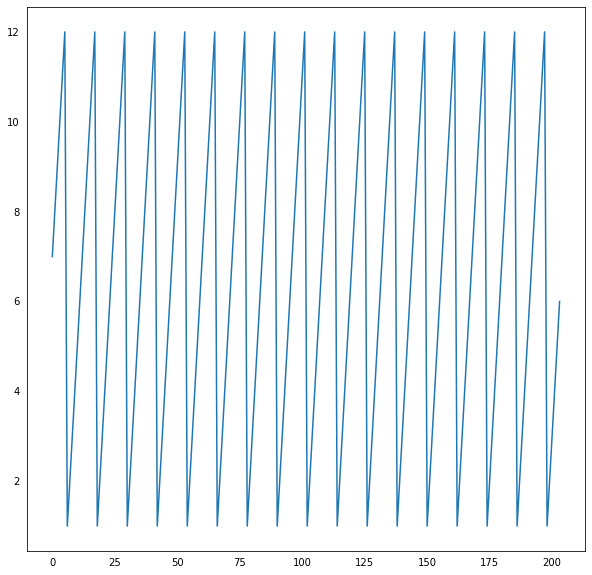

In [469]:
df_features.month.plot();

We could use time as we have transformed it, but to make it easier to use from a predictive model you need to transform it into a cyclic feature.  

You can then apply transformations: sin and cos type so as not to make time linear.

For more information:  
https://github.com/IanLondon/ianlondon.github.io/blob/master/_posts/blog/2016-07-31-encoding-cyclical-features-24hour-time.md

In [470]:
time_frame = 12 #months
df_features['sin_time'] = np.sin(2*np.pi*df_features.month/time_frame)
df_features['cos_time'] = np.cos(2*np.pi*df_features.month/time_frame)
df_features.head()

,value,month,year,sin_time,cos_time
0,3.526591,7,1991,-0.500000,-8.660254e-01
1,3.180891,8,1991,-0.866025,-5.000000e-01
2,3.252221,9,1991,-1.000000,-1.836970e-16
3,3.611003,10,1991,-0.866025,5.000000e-01
4,3.565869,11,1991,-0.500000,8.660254e-01


Plotting our new feature we get

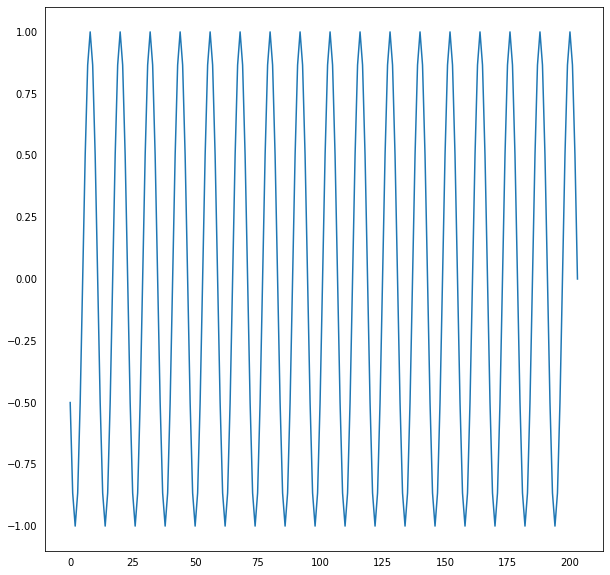

In [471]:
df_features.sin_time.plot()

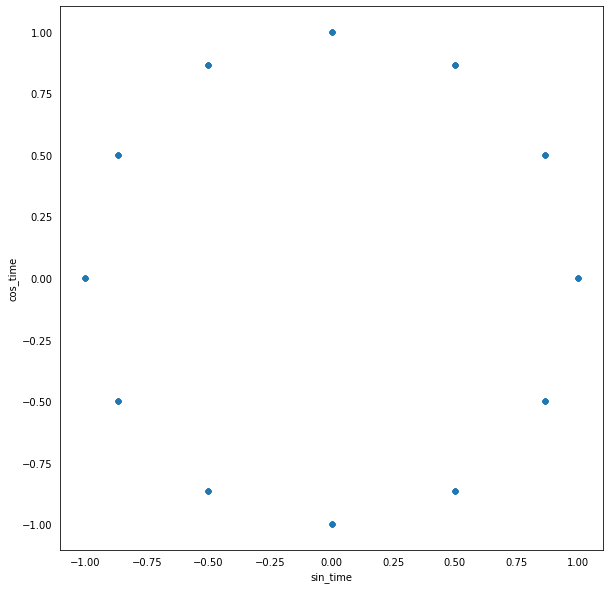

In [472]:
df_features.plot.scatter('sin_time','cos_time').set_aspect('equal');

Another interesting example that can be found:  
https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning